### Project 4 - Advance Lane Finding

Objective: Create a software pipeline to identify the lane boundaries in a video

Steps:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Images folder for camera calibration: camera_cal
<br> Images folder for testing pipeline on single frames: test_images
<br> Video for processing: project_video.mp4

Version 2: Single file - completed curve projection image and curvature text

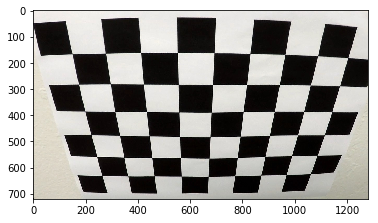

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Display image for testing
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)


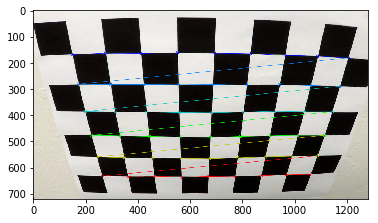

In [3]:
# Array to hold object points and image points from all the calibration images
objpoints = []                                              #3D points for real world space
imgpoints = []                                              #2D points for image plane

objp = np.zeros((6*9,3), np.float32)                        # Prepare object points - all zeros
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)              # x,y coordinates

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                 # Convert image to gray scale

ret, corners = cv2.findChessboardCorners(gray,(9,6),None)   # Find the chessboard corners from image

if ret == True:                                             # If corners are found, draw points on image
    imgpoints.append(corners)
    objpoints.append(objp)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.imshow(img)


In [4]:
import glob
#%matplotlib qt

calImages = glob.glob('./camera_cal/calibration*.jpg')          # Read in a bunch of sequential images

objpoints = []                                                  # 3D points for real world space
imgpoints = []                                                  # 2D points for image plane

objp = np.zeros((6*9,3), np.float32)                            # Prepare object points - all zeros
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)                  # x,y coordinates

for fname in calImages:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                 # Convert image to gray scale
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)   # Find the chessboard corners from image
    if ret == True:                                             # If corners are found
        imgpoints.append(corners)
        objpoints.append(objp)
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        plt.imshow(img)

# Determine parameters for camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera Distortion Parameters Acquired")



Camera Distortion Parameters Acquired


Text(0.5,1,'Undistorted Image')

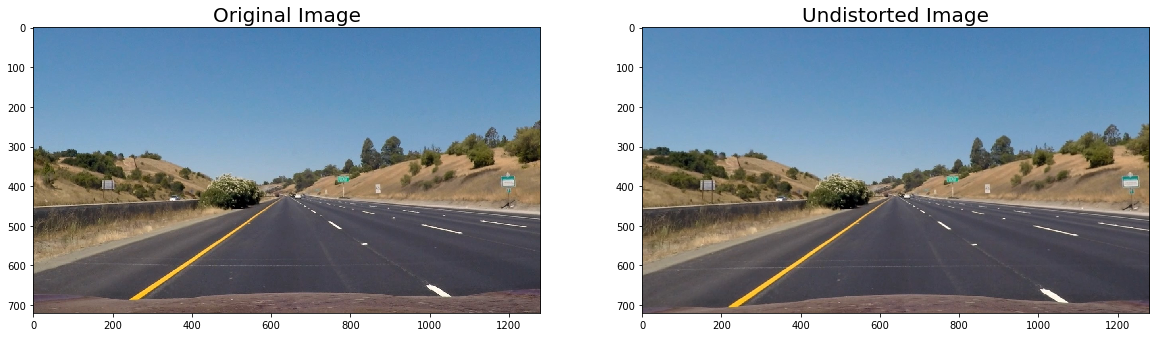

In [14]:
# Test camera parameters for distortion on an test image
imgdist = mpimg.imread('./test_images/straight_lines1.jpg')

# Destination image - undistort input image
dst = cv2.undistort(imgdist, mtx, dist, None, mtx)
#cv2.imwrite('./test_images/straight_lines1_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(imgdist)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)



Text(0.5,1,'Binary Gray Image')

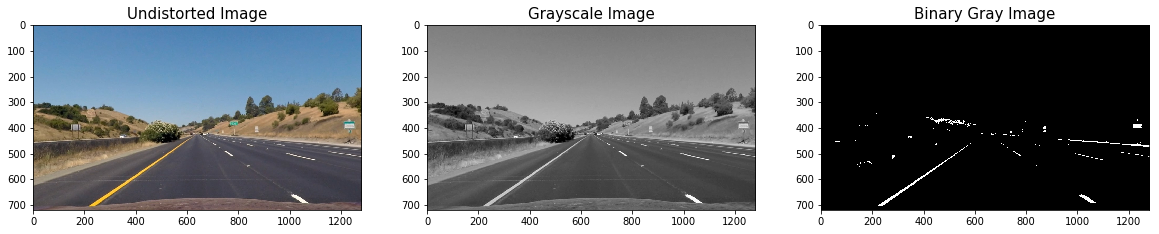

In [15]:
thresh = (180, 255)
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)                  # Grayscale conversion of undistorted image
binary = np.zeros_like(gray)                                  # Binary of grayscale
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=15)

ax2.imshow(gray, cmap='gray')
ax2.set_title('Grayscale Image', fontsize=15)

ax3.imshow(binary, cmap='gray')
ax3.set_title('Binary Gray Image', fontsize=15)



Text(0.5,1,'Threshold Sobel x Image')

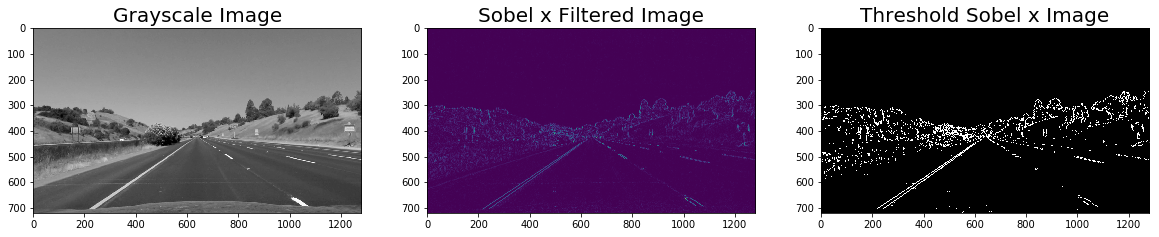

In [16]:
# Sobel x - grayscale

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                      # Take the derivative in x
abs_sobelx = np.absolute(sobelx)                                # Absolute x derivative 
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))      # 8 bit conversion

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(gray,cmap='gray')
ax1.set_title('Grayscale Image', fontsize=20)
ax2.imshow(scaled_sobel)
ax2.set_title('Sobel x Filtered Image', fontsize=20)
ax3.imshow(sxbinary,cmap='gray')
ax3.set_title('Threshold Sobel x Image', fontsize=20)

Text(0.5,1,'S Channel Image')

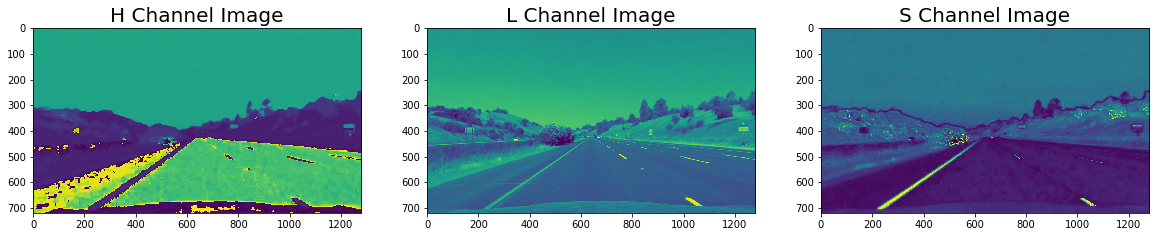

In [17]:
# HLS Color Space
hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)                 # Convert to HLS color space
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H)
ax1.set_title('H Channel Image', fontsize=20)
ax2.imshow(L)
ax2.set_title('L Channel Image', fontsize=20)
ax3.imshow(S)
ax3.set_title('S Channel Image', fontsize=20)


Text(0.5,1,'V Channel Image')

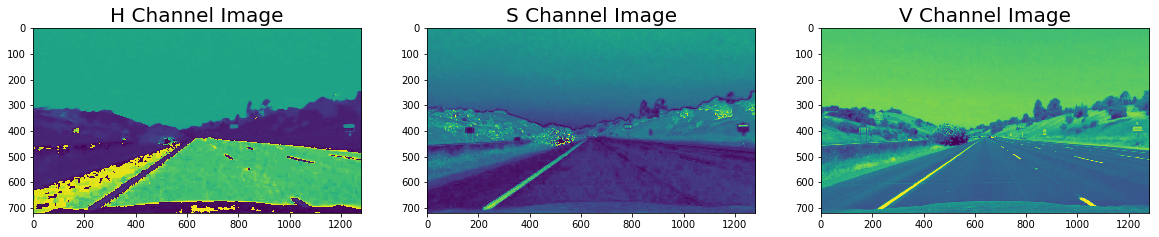

In [18]:
# HSV Color Space
hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)                 # Convert to HSV color space
H1 = hsv[:,:,0]
S1 = hsv[:,:,1]
V1 = hsv[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H1)
ax1.set_title('H Channel Image', fontsize=20)
ax2.imshow(S1)
ax2.set_title('S Channel Image', fontsize=20)
ax3.imshow(V1)
ax3.set_title('V Channel Image', fontsize=20)

Text(0.5,1,'Satuation Channel Threshold Image')

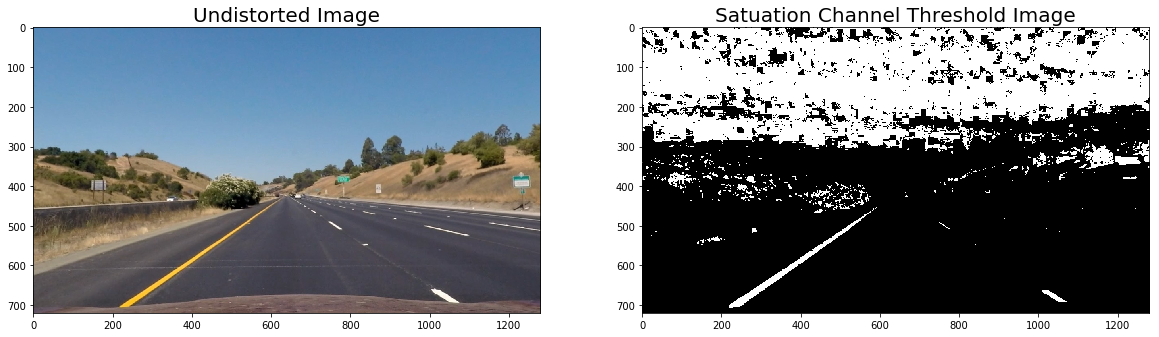

In [19]:
# HLS Thresholding - Saturation
threshS = (100, 255)
binaryS = np.zeros_like(S)
binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(binaryS, cmap='gray')
ax2.set_title('Satuation Channel Threshold Image', fontsize=20)


Text(0.5,1,'Value Channel Threshold Image')

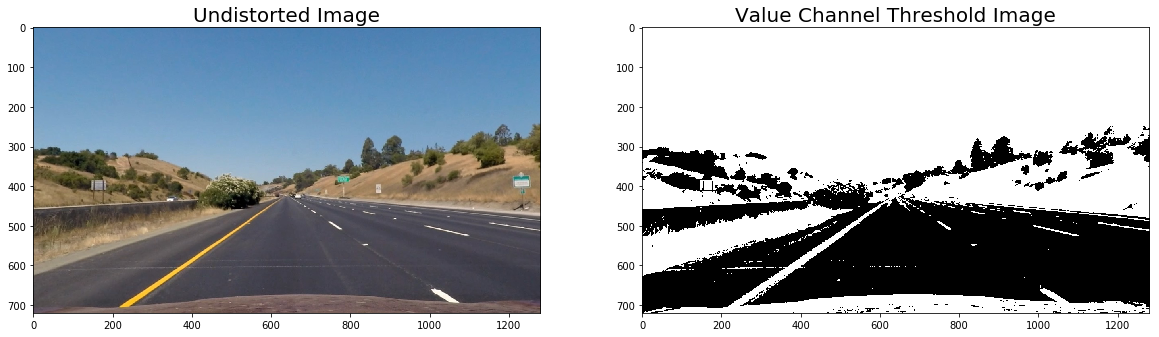

In [20]:
# HSV Thresholding - Value
threshV = (100, 255)
binaryV = np.zeros_like(S)
binaryV[(V1 > threshV[0]) & (V1 <= threshV[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(binaryV, cmap='gray')
ax2.set_title('Value Channel Threshold Image', fontsize=20)

Text(0.5,1,'Combined S,V,Gray & Sobel Binary Image')

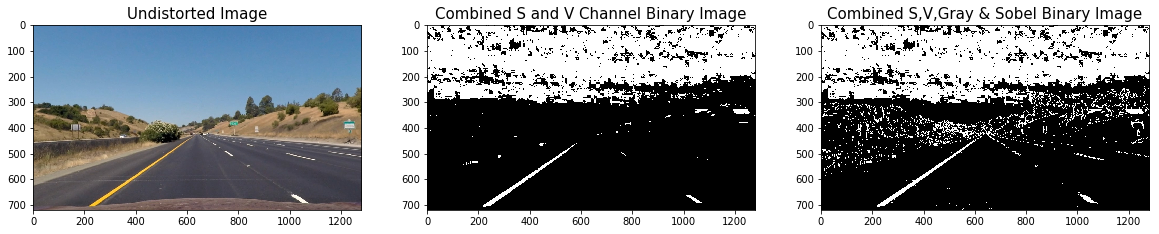

In [21]:
# V Channel from HSV image identify the left lane well even at great distance but the bright area are too bright
# S Channel identify the lane well at close distance despite lighting condition

combine_binaryVS = np.zeros_like(binaryS)
combine_binaryVS[(binaryS == 1) & (binaryV == 1)] = 1

combine_binaryVSg = np.zeros_like(sxbinary)
combine_binaryVSg[(combine_binaryVS == 1) | (sxbinary == 1)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(combine_binaryVS, cmap='gray')
ax2.set_title('Combined S and V Channel Binary Image', fontsize=15)
ax3.imshow(combine_binaryVSg, cmap='gray')
ax3.set_title('Combined S,V,Gray & Sobel Binary Image', fontsize=15)


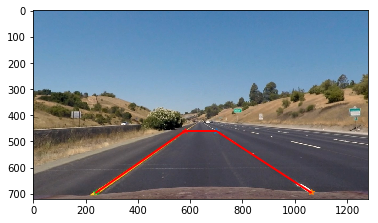

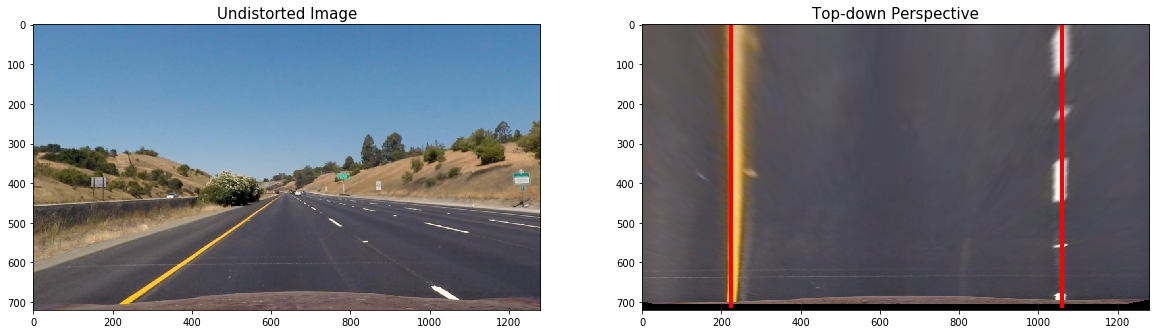

In [22]:
# Perspective Transform

plt.imshow(dst)
plt.plot(700,460,'*')        # Top-Right of Trapezoid
plt.plot(1061,695,'*')       # Bottom-Right of Trapezoid
plt.plot(241,695,'*')        # Bottom-Left of Trapezoid
plt.plot(580,460,'*')        # Top-Left of Trapezoid
plt.plot([1061,700], [695,460], color='red', linestyle='-', linewidth=2)
plt.plot([241,580], [695,460], color='red', linestyle='-', linewidth=2)
plt.plot([580,700], [460,460], color='red', linestyle='-', linewidth=2)

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[700,460],
         [1061,695],
         [241,695],
         [580,460]])         
    dstW = np.float32(
        [[1050,0],
         [1050,695],
         [225,695],
         [225,0]])
    
    M = cv2.getPerspectiveTransform(src, dstW)                           # Get transform matrix
    Minv = cv2.getPerspectiveTransform(dstW,src)                         # Get the inverse transform matrix
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return [warped, Minv]

warped_image, Minv = warp(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(warped_image)
ax2.set_title('Top-down Perspective', fontsize=15)
plt.plot([1060,1060], [0,710], color='red', linestyle='-', linewidth=4)
plt.plot([225,225], [0,710], color='red', linestyle='-', linewidth=4)

Text(0.5,1,'Top-down Perspective')

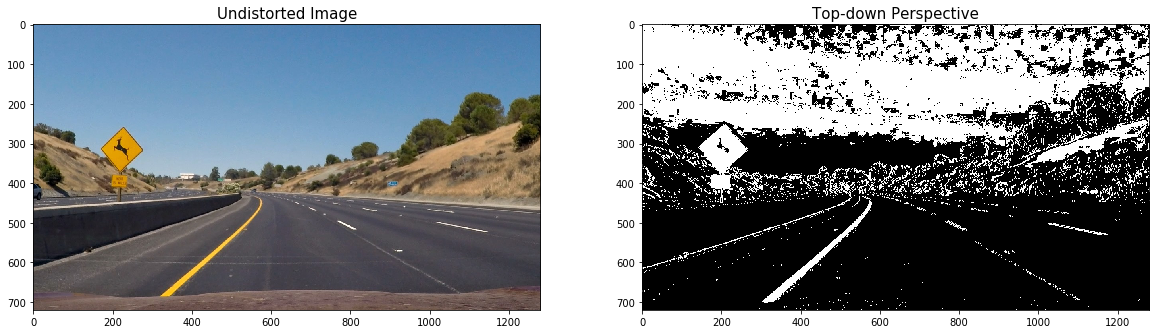

In [179]:
# Curve Line
threshG = (180, 255)
threshSolX = (20, 100)
threshS = (100, 255)
threshV = (100, 255)


imgcuv = mpimg.imread('./test_images/test2.jpg')

def ProcessImg(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)   
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)                  # Grayscale conversion of undistorted image
    binary = np.zeros_like(gray)                                  # Binary of grayscale
    binary[(gray > threshG[0]) & (gray <= threshG[1])] = 1
    
    # Sobel X and Thresholding
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                      # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)                                # Absolute x derivative 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))      # 8 bit conversion
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSolX[0]) & (scaled_sobel <= threshSolX[1])] = 1
    
    # Color Space and Thresholding
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)                 # Convert to HLS color space
    S = hls[:,:,2]
    hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)                 # Convert to HSV color space
    V = hsv[:,:,2]
    binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1
    binaryV[(V > threshV[0]) & (V <= threshV[1])] = 1
    
    sobelxSat = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                    # Take the derivative in x from Saturation image
    abs_sobelxSat = np.absolute(sobelxSat)                              # Absolute x derivative 
    scaled_sobelSat = np.uint8(255*abs_sobelxSat/np.max(abs_sobelxSat))    # 8 bit conversion
    
    # Combine V and S channel, then with Sobel X
    combine_binaryVS = np.zeros_like(binaryS)
    combine_binaryVS[(binaryS == 1) & (binaryV == 1)] = 1

    combine_binaryVSg = np.zeros_like(sxbinary)
    combine_binaryVSg[(combine_binaryVS == 1) | (sxbinary == 1)] = 1
    
    return combine_binaryVSg


processedImg = ProcessImg(imgcuv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(imgcuv)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(processedImg, cmap='gray')
ax2.set_title('Top-down Perspective', fontsize=15)
    

Text(0.5,1,'Histogram of Top View')

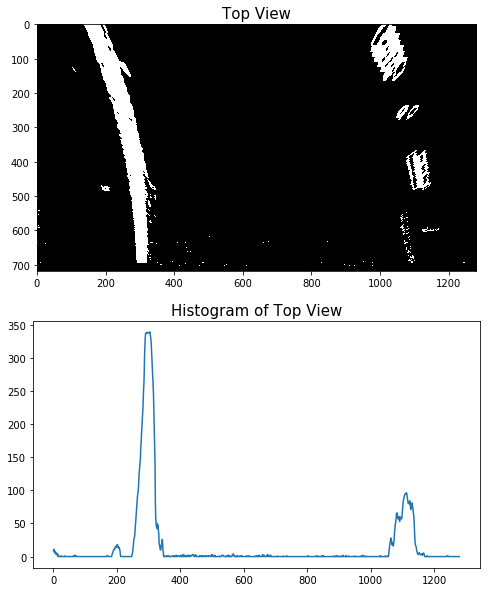

In [180]:
warped_image, Minv = warp(processedImg)
#plt.imshow(warped_image)

histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.imshow(warped_image,cmap='gray')
ax1.set_title('Top View', fontsize=15)
ax2.plot(histogram)
ax2.set_title('Histogram of Top View', fontsize=15)

In [181]:
out_img = np.dstack((warped_image, warped_image, warped_image))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])                           # Left lane is better defined in these images
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 10                                                          # Choose the number of sliding windows
window_height = np.int(warped_image.shape[0]/nwindows)                 # Set height of windows

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base                          # Current positions to be updated for each window
rightx_current = rightx_base

margin = 100                                        # Set the width of the windows +/- margin
minpix = 50                                         # Set minimum number of pixels found to recenter window
left_lane_inds = []                                 # Create empty lists to receive left and right lane pixel indices
right_lane_inds = []

for window in range(nwindows):                      # Step through the windows one by one 
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_image.shape[0] - (window+1)*window_height       
    win_y_high = warped_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &          
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]       
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

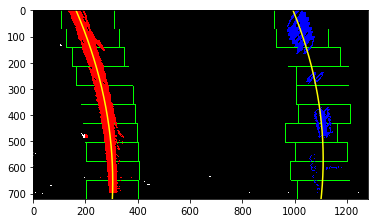

In [182]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [183]:
# Once the lane was found after the sliding window step
# Assume you now have a new warped binary image from the next frame of video

nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100

# Left Lane indexs
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

# Right Lane indexs
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


(720, 0)

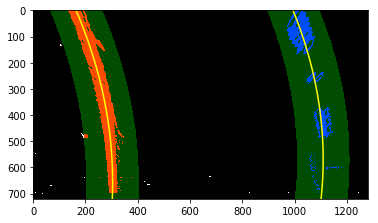

In [184]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_image, warped_image, warped_image))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area; recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [232]:
# Get the radius of curvature

# In Pixel Space
y_eval = np.max(ploty)
left_curveradP = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curveradP = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Curvature in Pixel Space - Left: {0:.1f}, Right: {1:.1f}".format(left_curveradP, right_curveradP))

# Curvature in meters after correcting for scale in x and y
ym_per_pix = 30/720                                                  # meters per pixel in y dimension
xm_per_pix = 3.7/700                                                 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curveradM = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curveradM = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print("Curvature in Real World Space - Left: {0:.1f}m, Right: {1:.1f}m".format(left_curveradM, right_curveradM))
CurveText = "Curvature: {0:.1f}m".format((left_curveradM+right_curveradM)/2)


Curvature in Pixel Space - Left: 1545.8, Right: 1431.9
Curvature in Real World Space - Left: 506.5m, Right: 462.5m


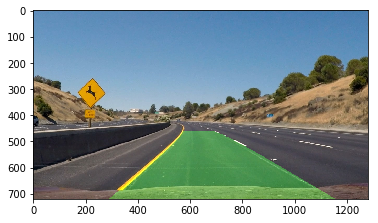

In [248]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (imgcuv.shape[1], imgcuv.shape[0]))

# Combine the result with the original image
result = cv2.addWeighted(imgcuv, 1, newwarp, 0.3, 0)
plt.imshow(result)

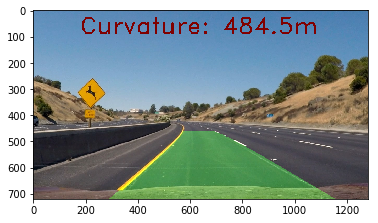

In [256]:
# Display result image with curvature information

font = cv2.FONT_HERSHEY_DUPLEX
resultwText = cv2.putText(result, CurveText, (180,90), font, 3, (128,0,0), 3)
plt.imshow(resultwText)


In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        self.detected = False                           # was the line detected in the last iteration?
        self.recent_xfitted = []                        # x values of the last n fits of the line       
        self.bestx = None                               #average x values of the fitted line over the last n iterations      
        self.best_fit = None                            #polynomial coefficients averaged over the last n iterations        
        self.current_fit = [np.array([False])]          #polynomial coefficients for the most recent fit         
        self.radius_of_curvature = None                 #radius of curvature of the line in some units         
        self.line_base_pos = None                       #distance in meters of vehicle center from the line        
        self.diffs = np.array([0,0,0], dtype='float')   #difference in fit coefficients between last and new fits        
        self.allx = None                                #x values for detected line pixels        
        self.ally = None                                #y values for detected line pixels
        
